# Color Coordinate System
Computer Graphics Assignment 5  
19M38254 - Roland Hartanto    

## Description
In this assignment, there are 13 pigment's spectral reflectances data given. The following are the pigment IDs.

\[1, 6, 15, 33, 41, 46, 51, 58, 64, 72, 74, 84, 92\]

The data format is <code>\[wavelength\] \[reflectance value\]</code>. For example:
```
400 	0.123853211009174  
401.171875 	0.123853211009174  
402.34375 	0.123853211009174  
...
```

The goals of this assignment are:
- Calculating the CIEXYZ1931 coordinate of the reflection of those pigments
- Calculating the color coordinate of the reflection of the pigments in sRGB(8bits) color space
- Find the brightest and darkest pigments

## Implementation
### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as constant

import os
import math
import re
import copy

from IPython.display import HTML, display

### Data loading from file

In [2]:
# load pigment relection data
data = {}
for root, directory, files in os.walk('Pigmentdata/'):
    for filename in files:
        data[int(filename[:-4])] = np.loadtxt('Pigmentdata/' + filename, skiprows=2)

# load ciexyz mapping function
ciexyz_mapping = {}
mapping_raw = np.loadtxt('XYZ_CIE_2.dat.txt')
for instance in mapping_raw:
    ciexyz_mapping[instance[0]] = [instance[1], instance[2], instance[3]]

w_ciexyz, x_ciexyz, y_ciexyz, z_ciexyz = np.hsplit(mapping_raw,4)
w_ciexyz = np.reshape(w_ciexyz, len(w_ciexyz))
x_ciexyz = np.reshape(x_ciexyz, len(x_ciexyz))
y_ciexyz = np.reshape(y_ciexyz, len(y_ciexyz))
z_ciexyz = np.reshape(z_ciexyz, len(z_ciexyz))

### Black-body radiation calculation (at 6504 K)

The calculation of black-body radiation uses the Planck's equation.  

$$ L_e(\lambda) = \frac{2c^2h}{\lambda^5 (e^{hc/kT\lambda} - 1)} $$

Where:
- $ \lambda $ is the wavelength
- $ c = 2.99792458 * 10^8 $ is the speed of light
- $ h = 6.6260755 * 10^{-34} $ is the Planck's constant
- $ k = 1.380658 * 10^{-23} $ is the Boltzmann's constant

In [28]:
c = 299792458.0
h = 6.6260755 * 1e-34
k = 1.380658 * 1e-23
def black_body_radiance(wavelength):
    w = wavelength * 1e-9
    radiance = (2 * (c**2) * h) / ((w**5) * (math.exp(h * c / (k * 6504 * w)) - 1))  
    return radiance

#### Radiance values from 380 nm to 780 nm

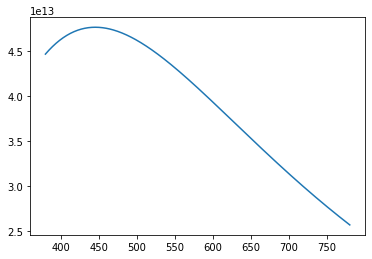

In [29]:
# standardize wavelength scaling
w = 380.078125
wavelengths = []
while w < 780:
    wavelengths.append(w)
    w += 1.171875

radiances = [black_body_radiance(w) for w in wavelengths]
plt.plot(wavelengths,radiances)
plt.show()

### CIEXYZ and sRGB color coordinate calculation

#### Functions
##### Calculating CIEXYZ from the spectral reflectances data
The calculation of XYZ coordinates is performed by summing the multiplications of CIEXYZ matching function and the spectral reflectances. In general, it can be written as below \[1\]:

$$ X = \frac{K}{N} \int_{\lambda}\: S(\lambda)\: I(\lambda)\: \overline{x}(\lambda)\; d\lambda $$
$$ Y = \frac{K}{N} \int_{\lambda}\: S(\lambda)\: I(\lambda)\: \overline{y}(\lambda)\; d\lambda $$
$$ Z = \frac{K}{N} \int_{\lambda}\: S(\lambda)\: I(\lambda)\: \overline{z}(\lambda)\; d\lambda $$
$$ N = \int_{\lambda}\: I(\lambda)\: \overline{y}(\lambda)\; d\lambda $$

with K is the scaling factor (in the implementation $K=1$), and the wavelength $\lambda \in [380,780]$.

Since the data is discrete, the formula is a bit modified.
$$ X = \frac{K}{N} \sum_{\lambda}\: S(\lambda)\: I(\lambda)\: \overline{x}(\lambda)\; \Delta\lambda $$
$$ Y = \frac{K}{N} \sum_{\lambda}\: S(\lambda)\: I(\lambda)\: \overline{y}(\lambda)\; \Delta\lambda $$
$$ Z = \frac{K}{N} \sum_{\lambda}\: S(\lambda)\: I(\lambda)\: \overline{z}(\lambda)\; \Delta\lambda $$
$$ N = \sum_{\lambda}\: I(\lambda)\: \overline{y}(\lambda)\; \Delta\lambda $$


##### Calculating sRGB color

To calculate the sRGB, we can apply a transformation matrix to the XYZ coordinate.
First, calculate the linear RGB values from XYZ coordinate.    
$$ R' = 3.2406\: X + (-1.5372)\: Y + (-0.4986)\: Z $$
$$ G' = -0.9689)\: X + (1.8758)\: Y + 0.0415\: Z $$
$$ B' = 0.0557\: X + (-0.2040)\: Y + 1.0570\: Z $$  
Those values (R', G', and B') are clipped to 0.0 and 1.0. Thus, if the value is greater than 1.0, it will be set to 1.0 and if the value si smaller than 0.0 it will be set to 0.0.  
Then, we calculate the nonlinear RGB values from R', G', and B'. We get the nonlinear RGB by performing the following procedure.

If $ \; R'\:$ or $\:G'\:$ or $\:B'\:$ $< 0.0031308\; $ then  

$$ R_{sRGB} = 12.92\:R' $$
$$ G_{sRGB} = 12.92\:G' $$
$$ B_{sRGB} = 12.92\:B' $$  
else  
$$ R_{sRGB} = 1.055\:R'^{1.0/2.4} - 0.055 $$
$$ G_{sRGB} = 1.055\:G'^{1.0/2.4} - 0.055 $$
$$ B_{sRGB} = 1.055\:B'^{1.0/2.4} - 0.055 $$

Those sRGB values are tranformed into 8bit integers by doing the following step:  

$$ R_{8bit} = round(255\: R_{sRGB}) $$
$$ G_{8bit} = round(255\: G_{sRGB}) $$
$$ B_{8bit} = round(255\: B_{sRGB}) $$


In [45]:
def ciexyz_from_radiances(wavelengths, radiances, percentages):
    interp_x = np.interp(wavelengths, w_ciexyz, x_ciexyz)
    interp_y = np.interp(wavelengths, w_ciexyz, y_ciexyz)
    interp_z = np.interp(wavelengths, w_ciexyz, z_ciexyz)
    
    x = 0
    y = 0
    z = 0
    n = 0
    
    j = 0
    for i in range(0, len(wavelengths)):
        if wavelengths[i] <= 400.0:
            reflected = radiances[i] * percentages[0][1]
        elif wavelengths[i] > 698.828125:
            reflected = radiances[i] * percentages[len(percentages) - 1][1]
        else:
            reflected = radiances[i] * percentages[j][1]
            j += 1
        x += interp_x[i] * reflected * 1.171875
        y += interp_y[i] * reflected * 1.171875
        z += interp_z[i] * reflected * 1.171875
        n += interp_y[i] * radiances[i] * 1.171875
    
    return x/n, y/n, z/n

def clip_value(value, bottom_limit, upper_limit):
    if (value > upper_limit):
        return 1.0
    elif (value < bottom_limit):
        return 0.0
    else:
        return value

def linear_to_nonlinear_rgb(color_linear):
    constant = 0.0031308
    if color_linear < constant:
        return 12.92 * color_linear
    else:
        return (1.055 * color_linear**(1.0/2.4)) - 0.055

def convert_xyz_to_rgb(xyz):
    r_t = clip_value(3.2406 * xyz[0] + (-1.5372) * xyz[1] + (-0.4986) * xyz[2], 0.0, 1.0)
    g_t = clip_value((-0.9689) * xyz[0] + (1.8758) * xyz[1] + 0.0415 * xyz[2], 0.0, 1.0)
    b_t = clip_value(0.0557 * xyz[0] + (-0.2040) * xyz[1] + 1.0570 * xyz[2], 0.0, 1.0)    
    
    r_srgb = round(255 * linear_to_nonlinear_rgb(r_t))
    g_srgb = round(255 * linear_to_nonlinear_rgb(g_t))
    b_srgb = round(255 * linear_to_nonlinear_rgb(b_t))
    
    return r_srgb, g_srgb, b_srgb

In [46]:
brightest_pigment_id = -1
darkest_pigment_id = -1
brightest = -9999999
darkest = 9999999

colors = {}
for id in data:
    ciexyz = ciexyz_from_radiances(wavelengths, radiances, data[id])
    srgb = convert_xyz_to_rgb(ciexyz)
    colors[id] = {'ciexyz': ciexyz, 'srgb': srgb}
    if brightest < ciexyz[1]:
        brightest = ciexyz[1]
        brightest_pigment_id = id
    if darkest > ciexyz[1]:
        darkest = ciexyz[1]
        darkest_pigment_id = id

### Result

In [47]:
html = '''
<div style="padding-bottom: 5px; margin: 10px 0px 10px 0px; display:flex; flex-direction: row; align-items: center; border-bottom: solid black 1px;">
    <div style="width:30px;"><strong>ID</strong></div>
    <div style="width:60px; padding-left:10px"><strong>Color</strong></div>
    <div>
        <div style="margin-left: 10px"><strong>CIEXYZ & sRGB</strong></div>
    </div>
</div>
'''
display(HTML(html))
    
for i in sorted(colors):
    html = '''
<div style="display:flex; flex-direction: row; align-items: center">
    <div style="width:30px;">ID</div>
    <div><svg height="60" width="60"><rect x="5" y="5" width="50" height="50" fill="rgbCOLOR_TEMPLATE" /></svg></div>
    <div>
        <div style="margin-left: 10px">CIEXYZ : COLOR_XYZ</div>
        <div style="margin-left: 10px">RGB : COLOR_TEMPLATE</div>
    </div>
</div>
'''
    display(HTML(html.replace('COLOR_TEMPLATE', str(colors[i]['srgb']))\
                 .replace('ID', str(i)).replace('COLOR_XYZ', str(colors[i]['ciexyz']))))
    
print('Brightest Pigment:', brightest_pigment_id, '(' + str(brightest) + ')')
print('Darkest Pigment:', darkest_pigment_id, '(' + str(darkest) + ')')


Brightest Pigment: 46 (0.9021640274795708)
Darkest Pigment: 33 (0.04035874439461886)


## References

\[1\] https://en.wikipedia.org/wiki/CIE_1931_color_space